## Fig 3a

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Network_bayesian import Place_net, Grid_net, Coupled_Net
import brainpy as bp
import brainpy.math as bm
from matplotlib.animation import FuncAnimation
import time
from scipy.stats import ttest_ind, norm
import seaborn as sns

/home/yulingwu/miniconda3/envs/CCS_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


T-test p-value: 0.86375


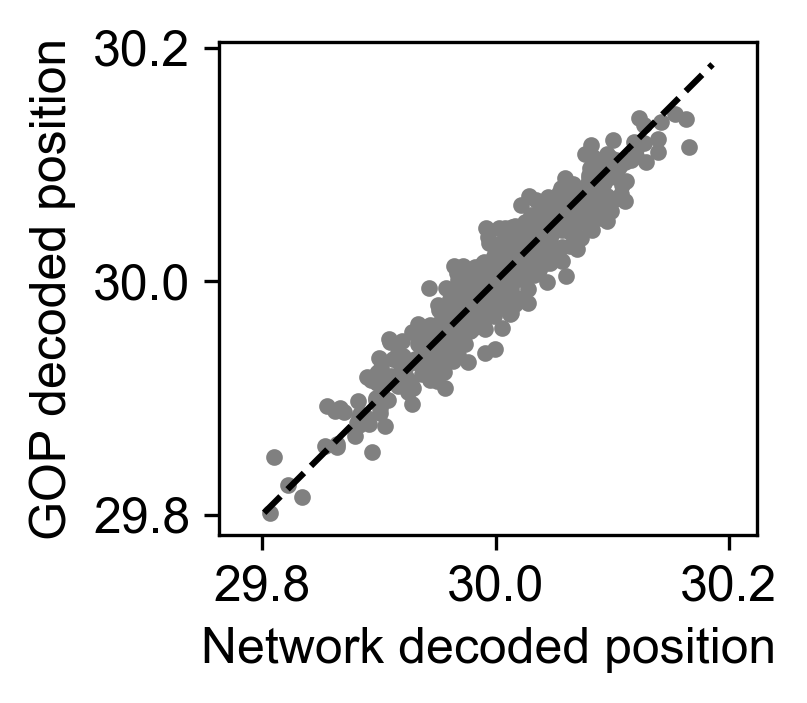

In [3]:
# Load data
data = np.load('data/distribution_results.npz') # 500 trials
z_decode_gop = data['z_decode_gop']
z_decode_net = data['z_decode_net']

# Calculate t-test results and output p-values
t_stat, p_value = ttest_ind(z_decode_gop, z_decode_net)
print(f"T-test p-value: {p_value:.5f}")

# Set Font
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# Plot
plt.figure(figsize=(2.8, 2.5), dpi=300)
z_decode_all = np.concatenate([z_decode_gop, z_decode_net])
min_z = np.min(z_decode_all)
max_z = np.max(z_decode_all)

plt.plot(z_decode_net, z_decode_gop, '.', color='gray')
plt.xticks([29.8, 30, 30.2])
plt.yticks([29.8, 30, 30.2])
plt.plot([min_z, max_z+0.02], [min_z, max_z+0.02], 'k--')
plt.xlabel('Network decoded position')
plt.ylabel('GOP decoded position')
plt.axis('equal')  # Set equal aspect ratio
plt.tight_layout()
# plt.savefig('figures/net_gop_comparison.eps')

## Fig 3e

In [3]:
# Load data
data = np.load('data/results.npz') # 100 trials

mean_integrate_net = data['mean_integrate_net']
mean_motion_net = data['mean_motion_net']
mean_visual_net = data['mean_visual_net']
mean_integrate_gop = data['mean_integrate_gop']
std_integrate_net = data['std_integrate_net']
std_motion_net = data['std_motion_net']
std_visual_net = data['std_visual_net']
std_integrate_gop = data['std_integrate_gop']
error_int_net = data['error_int_net']
error_mot_net = data['error_mot_net']
error_vis_net = data['error_vis_net']

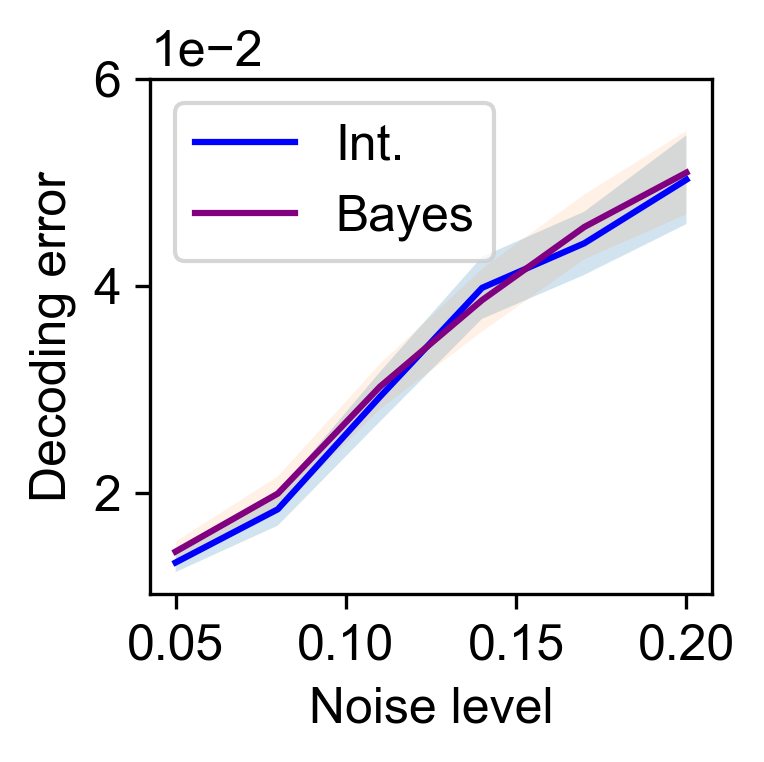

In [4]:
n_stre = 6
noise_stre = np.linspace(0.05, 0.2, n_stre)

plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# Custom Colors
colors = ['#2196F3', '#d62728', '#2ca02c', '#9467bd']

# Plot
plt.figure(figsize=(2.7, 2.7), dpi=300)

plt.plot(noise_stre, mean_integrate_net, label='Int.', color='blue')
plt.fill_between(noise_stre, mean_integrate_net - std_integrate_net/10, mean_integrate_net + std_integrate_net/10, alpha=0.2)

plt.plot(noise_stre, mean_integrate_gop, label='Bayes', color='purple')
plt.fill_between(noise_stre, mean_integrate_gop - std_integrate_gop/10, mean_integrate_gop + std_integrate_gop/10, alpha=0.1)

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel('Noise level')
plt.ylabel('Decoding error')
plt.legend()

plt.xticks([0.05, 0.1, 0.15, 0.2])
plt.yticks([0.02, 0.04, 0.06])

plt.tight_layout()
# plt.savefig('figures/Bayesian_integration.eps')
plt.show()


## Fig 3d

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [6]:
n = 100 # Number of trials
n_stre = 6
noise_stre = np.linspace(0.05, 0.2, n_stre)
# Calculate the index when noise=0.2
idx = np.where(np.isclose(noise_stre, 0.2))[0][0]

# Extract the mean and standard deviation for the three networks at noise=0.2
mean_errors = [
  mean_motion_net[idx],
  mean_visual_net[idx],
  mean_integrate_net[idx]
]
std_errors = [
  std_motion_net[idx],
  std_visual_net[idx],
  std_integrate_net[idx]
]
labels = ['Mot.', 'Env.', 'Int.']
# Custom colors
colors = ['red', '#ffc048', 'blue']

# Perform paired t-tests
p_values = []
comparisons = [(0, 1), (0, 2), (1, 2)]  # Compare Mot vs Env, Mot vs Int, Env vs Int

# Paired t-test
t_stat_mot_int, p_value_mot_int = stats.ttest_rel(error_mot_net, error_int_net)
t_stat_vis_int, p_value_vis_int = stats.ttest_rel(error_vis_net, error_int_net)
t_stat_mot_vis, p_value_mot_vis = stats.ttest_rel(error_mot_net, error_vis_net)

p_values = [p_value_mot_vis, p_value_mot_int, p_value_vis_int]

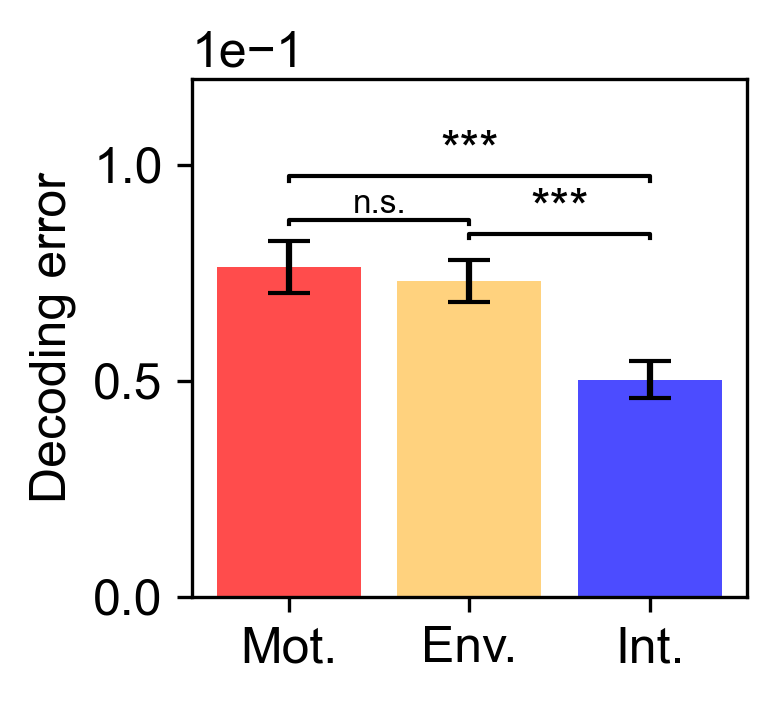

In [7]:
# Plot
plt.figure(figsize=(2.75, 2.5), dpi=300)
yerr = [
  std_motion_net[idx]/10,
  std_visual_net[idx]/10,
  std_integrate_net[idx]/10
]
bars = plt.bar(range(3), mean_errors, yerr=yerr, color=colors, alpha=0.7, capsize=5)
plt.xticks(range(3), labels)
plt.ylabel('Decoding error')
plt.yticks([0, 0.05, 0.1])
plt.ylim(0, 0.12)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.tight_layout()

# Add significance markers
def add_significance(i, j, p_val, y_offset=0.05):
  """Add a significance marker between columns i and j."""
  x1, x2 = i, j
  y = max(mean_errors[i], mean_errors[j]) + y_offset
  h = 0.01 * y
  plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c='k')
  if p_val < 0.001:
    plt.text((x1+x2)*0.5, y+h, '***', ha='center', va='bottom')
  elif p_val < 0.01:
    plt.text((x1+x2)*0.5, y+h, '**', ha='center', va='bottom')
  elif p_val < 0.05:
    plt.text((x1+x2)*0.5, y+h, '*', ha='center', va='bottom')
  else:
    plt.text((x1+x2)*0.5, y+h, 'n.s.', ha='center', va='bottom', fontsize=8)

# Annotate all comparisons
y_offsets = [0.01, 0.02, 0.01]  # Avoid overlap
for (i, j), p_val, y_offset in zip(comparisons, p_values, y_offsets):
  add_significance(i, j, p_val, y_offset)

plt.show()